In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lstm_baseline import LSTMModel

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.linear(hn[-1])

class SP500Transformer(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super(SP500Transformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)

        def get_sinusoidal_encoding(seq_len, d_model):
            position = torch.arange(seq_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
            pe = torch.zeros(seq_len, d_model)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            return pe

        self.register_buffer('pos_encoding', get_sinusoidal_encoding(seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoding
        x = self.encoder(x)
        x = x[:, -1, :]
        return self.output_layer(x)

class FXNet(nn.Module):
    def __init__(self, state_dim, hidden_dim=256):
        super(FXNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        return self.net(x)


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',       # Federal Funds Rate
    'UNRATE',         # Unemployment Rate
    'GS10',           # 10-Year Treasury Yield
    'DTWEXBGS',       # Dollar Index
    'DCOILWTICO',     # Oil Prices
    'GOLD',           # Gold Prices
    'MOVE',           # MOVE Index
    'VIXCLS'          # Volatility Index (VIX)
]

technical_features = [
    'SMA_10',         # 10-day Simple Moving Average
    'SMA_50',         # 50-day Simple Moving Average
    'EMA_10',         # 10-day Exponential Moving Average
    'EMA_50',         # 50-day Exponential Moving Average
    'ROC_10',         # 10-day Rate of Change
    'RSI_14',         # 14-day Relative Strength Index
    'BB_upper',       # Upper Bollinger Band
    'BB_lower',       # Lower Bollinger Band
    'Volatility_20'   # 20-day Rolling Volatility
]

df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

seq_length = 20

macro_scaler = MinMaxScaler()
X_macro_scaled = macro_scaler.fit_transform(X_macro)

tech_scaler = MinMaxScaler()
X_technical_scaled = tech_scaler.fit_transform(X_technical)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_macro)  

X_macro_seq, y_macro_seq = create_sequences(X_macro_scaled, y_scaled, seq_length)
X_technical_seq, y_technical_seq = create_sequences(X_technical_scaled, y_scaled, seq_length)


def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_macro_seq, y_macro_seq)

/var/folders/5t/_mmy5kjx1yn0xc44547b62pr0000gn/T/ipykernel_69933/50752790.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load("lstm_model_macro_signals.pth", map_location=device)
transformer_model = torch.load("sp500_transformer_macro.pth", map_location=device)
fx_net = torch.load("fxnet_macro.pth", map_location=device)
lstm_model.eval()
transformer_model.eval()
fx_net.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_macro_seq, y_macro_seq)

for model in [lstm_model, transformer_model, fx_net]:
    model.eval()
    for param in model.parameters():
        param.requires_grad = False


class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_experts=3):
        super(GatingNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


class MoEModel(nn.Module):
    def __init__(self, lstm, transformer, fx_net, input_dim):
        super(MoEModel, self).__init__()
        self.lstm = lstm
        self.transformer = transformer
        self.fx_net = fx_net
        self.gating = GatingNetwork(input_dim=input_dim, num_experts=3)

    def forward(self, x_macro):
        last_step = x_macro[:, -1, :] 

        lstm_out = self.lstm(x_macro)
        transformer_out = self.transformer(x_macro)

        kalman_preds = []
        for i in range(last_step.size(0)):
            with torch.no_grad():
                pred = self.fx_net(last_step[i].unsqueeze(0).to(device))
            kalman_preds.append(pred[0, 0].item())
        kalman_out = torch.tensor(kalman_preds, dtype=torch.float32, device=x_macro.device).unsqueeze(1)

        weights = self.gating(last_step)  

        out = (
            weights[:, 0:1] * lstm_out +
            weights[:, 1:2] * transformer_out +
            weights[:, 2:3] * kalman_out
        )
        return out, weights


moe = MoEModel(
    lstm=lstm_model,
    transformer=transformer_model,
    fx_net=fx_net,
    input_dim=X_macro_seq.shape[2]
).to(device)

optimizer = optim.Adam(moe.gating.parameters(), lr=1e-3)
criterion = nn.MSELoss()

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)


epochs = 100
for epoch in range(epochs):
    moe.train()
    total_train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred, _ = moe(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    moe.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = moe(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(val_loader):.4f}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/100 | Train Loss: 0.0288 | Val Loss: 0.0235
Epoch 2/100 | Train Loss: 0.0199 | Val Loss: 0.0159
Epoch 3/100 | Train Loss: 0.0128 | Val Loss: 0.0125
Epoch 4/100 | Train Loss: 0.0100 | Val Loss: 0.0118
Epoch 5/100 | Train Loss: 0.0090 | Val Loss: 0.0118
Epoch 6/100 | Train Loss: 0.0073 | Val Loss: 0.0119
Epoch 7/100 | Train Loss: 0.0078 | Val Loss: 0.0119
Epoch 8/100 | Train Loss: 0.0074 | Val Loss: 0.0119
Epoch 9/100 | Train Loss: 0.0076 | Val Loss: 0.0119
Epoch 10/100 | Train Loss: 0.0084 | Val Loss: 0.0119
Epoch 11/100 | Train Loss: 0.0078 | Val Loss: 0.0119
Epoch 12/100 | Train Loss: 0.0076 | Val Loss: 0.0119
Epoch 13/100 | Train Loss: 0.0081 | Val Loss: 0.0119
Epoch 14/100 | Train Loss: 0.0076 | Val Loss: 0.0119
Epoch 15/100 | Train Loss: 0.0080 | Val Loss: 0.0119
Epoch 16/100 | Train Loss: 0.0080 | Val Loss: 0.0119
Epoch 17/100 | Train Loss: 0.0078 | Val Loss: 0.0119
Epoch 18/100 | Train Loss: 0.0072 | Val Loss: 0.0119
Epoch 19/100 | Train Loss: 0.0078 | Val Loss: 0.0119
Ep

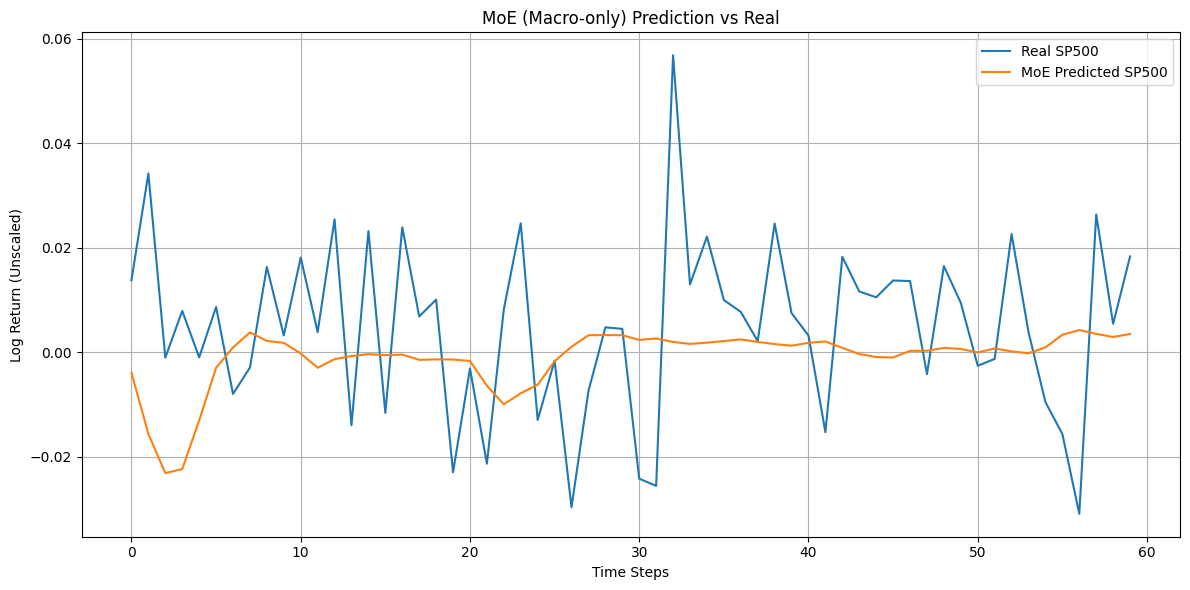

Directional Accuracy: 55.93%
Mean Squared Error: 0.000352


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)
moe.eval()
preds = []
weights_all = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out, weights = moe(xb)
        preds.append(out.cpu().numpy())
        weights_all.append(weights.cpu().numpy())

preds = np.vstack(preds)
weights_all = np.vstack(weights_all)


sp500_pred = y_scaler.inverse_transform(preds)
sp500_real = y_scaler.inverse_transform(y_test.cpu().numpy())
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(real, pred)

plt.figure(figsize=(12, 6))
plt.plot(real, label="Real SP500")
plt.plot(pred, label="MoE Predicted SP500")
plt.title("MoE (Macro-only) Prediction vs Real")
plt.xlabel("Time Steps")
plt.ylabel("Log Return (Unscaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f"Mean Squared Error: {mse:.6f}")

In [6]:
avg_weights = np.mean(weights_all, axis=0)
print("Average Gating Weights over Test Set:")
print(f"  LSTM        : {avg_weights[0]:.4f}")
print(f"  Transformer : {avg_weights[1]:.4f}")
print(f"  Kalman/FXNet: {avg_weights[2]:.4f}")


Average Gating Weights over Test Set:
  LSTM        : 0.2435
  Transformer : 0.7562
  Kalman/FXNet: 0.0002


Epoch 1/200 | Train Loss: 0.0172 | Val Loss: 0.0131
Epoch 2/200 | Train Loss: 0.0125 | Val Loss: 0.0130
Epoch 3/200 | Train Loss: 0.0100 | Val Loss: 0.0129
Epoch 4/200 | Train Loss: 0.0085 | Val Loss: 0.0129
Epoch 5/200 | Train Loss: 0.0085 | Val Loss: 0.0129
Epoch 6/200 | Train Loss: 0.0077 | Val Loss: 0.0129
Epoch 7/200 | Train Loss: 0.0081 | Val Loss: 0.0129
Epoch 8/200 | Train Loss: 0.0075 | Val Loss: 0.0129
Epoch 9/200 | Train Loss: 0.0080 | Val Loss: 0.0129
Epoch 10/200 | Train Loss: 0.0075 | Val Loss: 0.0129
Epoch 11/200 | Train Loss: 0.0075 | Val Loss: 0.0129
Epoch 12/200 | Train Loss: 0.0079 | Val Loss: 0.0129
Epoch 13/200 | Train Loss: 0.0075 | Val Loss: 0.0129
Epoch 14/200 | Train Loss: 0.0077 | Val Loss: 0.0129
Epoch 15/200 | Train Loss: 0.0079 | Val Loss: 0.0129
Epoch 16/200 | Train Loss: 0.0074 | Val Loss: 0.0129
Epoch 17/200 | Train Loss: 0.0075 | Val Loss: 0.0129
Epoch 18/200 | Train Loss: 0.0075 | Val Loss: 0.0129
Epoch 19/200 | Train Loss: 0.0073 | Val Loss: 0.0129
Ep

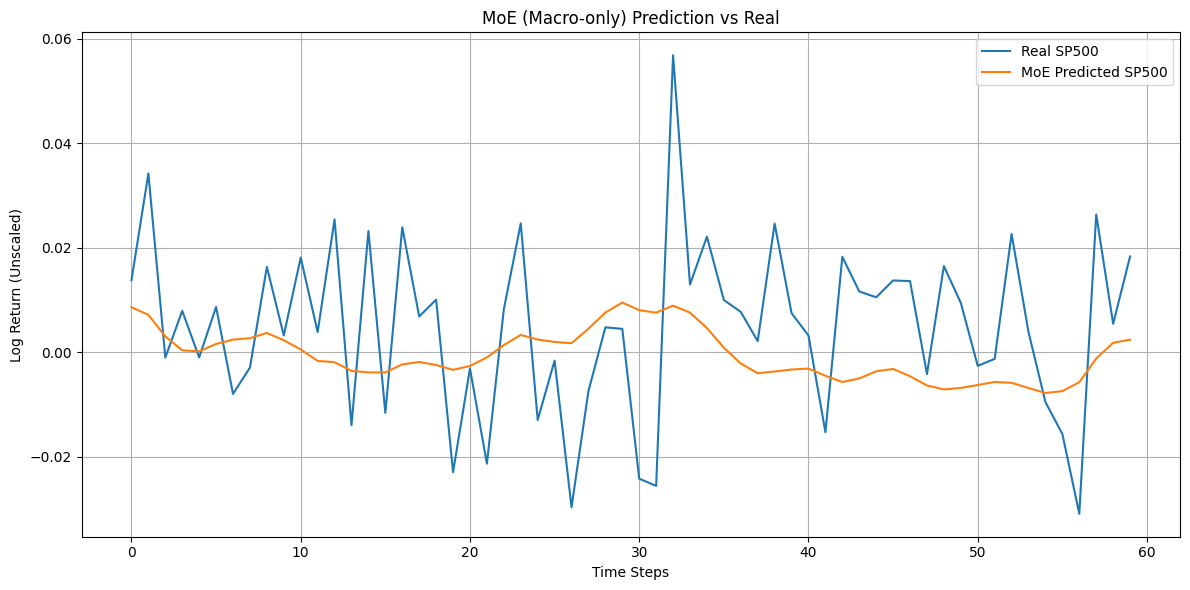

Directional Accuracy: 59.32%
Mean Squared Error: 0.000301
Average Gating Weights over Test Set:
  LSTM        : 0.9356
  Transformer : 0.0644
  Kalman/FXNet: 0.0000


In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_technical_seq, y_technical_seq)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm_model = torch.load("lstm_model_technical_signals.pth", map_location=device)
transformer_model = torch.load("sp500_transformer_technical.pth", map_location=device)
fx_net = torch.load("fxnet_technical.pth", map_location=device)

lstm_model.eval()
transformer_model.eval()
fx_net.eval()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model in [lstm_model, transformer_model, fx_net]:
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_experts=3):
        super(GatingNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


class MoEModel(nn.Module):
    def __init__(self, lstm, transformer, fx_net, input_dim):
        super(MoEModel, self).__init__()
        self.lstm = lstm
        self.transformer = transformer
        self.fx_net = fx_net
        self.gating = GatingNetwork(input_dim=input_dim, num_experts=3)

    def forward(self, x_macro):
        last_step = x_macro[:, -1, :]  

        lstm_out = self.lstm(x_macro)
        transformer_out = self.transformer(x_macro)

        kalman_preds = []
        for i in range(last_step.size(0)):
            with torch.no_grad():
                pred = self.fx_net(last_step[i].unsqueeze(0).to(device))
            kalman_preds.append(pred[0, 0].item())
        kalman_out = torch.tensor(kalman_preds, dtype=torch.float32, device=x_macro.device).unsqueeze(1)

        weights = self.gating(last_step)  

        out = (
            weights[:, 0:1] * lstm_out +
            weights[:, 1:2] * transformer_out +
            weights[:, 2:3] * kalman_out
        )
        return out, weights

moe = MoEModel(
    lstm=lstm_model,
    transformer=transformer_model,
    fx_net=fx_net,
    input_dim=X_technical_seq.shape[2]
).to(device)

optimizer = optim.Adam(moe.gating.parameters(), lr=1e-3)
criterion = nn.MSELoss()
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)


epochs = 200
for epoch in range(epochs):
    moe.train()
    total_train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred, _ = moe(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    moe.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = moe(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(val_loader):.4f}")


    import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)
moe.eval()
preds = []
weights_all = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out, weights = moe(xb)
        preds.append(out.cpu().numpy())
        weights_all.append(weights.cpu().numpy())

preds = np.vstack(preds)
weights_all = np.vstack(weights_all)


sp500_pred = y_scaler.inverse_transform(preds)
sp500_real = y_scaler.inverse_transform(y_test.cpu().numpy())
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(real, pred)

plt.figure(figsize=(12, 6))
plt.plot(real, label="Real SP500")
plt.plot(pred, label="MoE Predicted SP500")
plt.title("MoE (Macro-only) Prediction vs Real")
plt.xlabel("Time Steps")
plt.ylabel("Log Return (Unscaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f"Mean Squared Error: {mse:.6f}")
avg_weights = np.mean(weights_all, axis=0)
print("Average Gating Weights over Test Set:")
print(f"  LSTM        : {avg_weights[0]:.4f}")
print(f"  Transformer : {avg_weights[1]:.4f}")
print(f"  Kalman/FXNet: {avg_weights[2]:.4f}")

Epoch 1/200 | Train Loss: 0.0276 | Val Loss: 0.0198
Epoch 2/200 | Train Loss: 0.0200 | Val Loss: 0.0129
Epoch 3/200 | Train Loss: 0.0131 | Val Loss: 0.0118
Epoch 4/200 | Train Loss: 0.0106 | Val Loss: 0.0125
Epoch 5/200 | Train Loss: 0.0093 | Val Loss: 0.0129
Epoch 6/200 | Train Loss: 0.0092 | Val Loss: 0.0130
Epoch 7/200 | Train Loss: 0.0091 | Val Loss: 0.0129
Epoch 8/200 | Train Loss: 0.0088 | Val Loss: 0.0130
Epoch 9/200 | Train Loss: 0.0097 | Val Loss: 0.0130
Epoch 10/200 | Train Loss: 0.0089 | Val Loss: 0.0130
Epoch 11/200 | Train Loss: 0.0091 | Val Loss: 0.0130
Epoch 12/200 | Train Loss: 0.0098 | Val Loss: 0.0131
Epoch 13/200 | Train Loss: 0.0090 | Val Loss: 0.0132
Epoch 14/200 | Train Loss: 0.0086 | Val Loss: 0.0133
Epoch 15/200 | Train Loss: 0.0107 | Val Loss: 0.0133
Epoch 16/200 | Train Loss: 0.0093 | Val Loss: 0.0131
Epoch 17/200 | Train Loss: 0.0090 | Val Loss: 0.0132
Epoch 18/200 | Train Loss: 0.0093 | Val Loss: 0.0133
Epoch 19/200 | Train Loss: 0.0101 | Val Loss: 0.0132
Ep

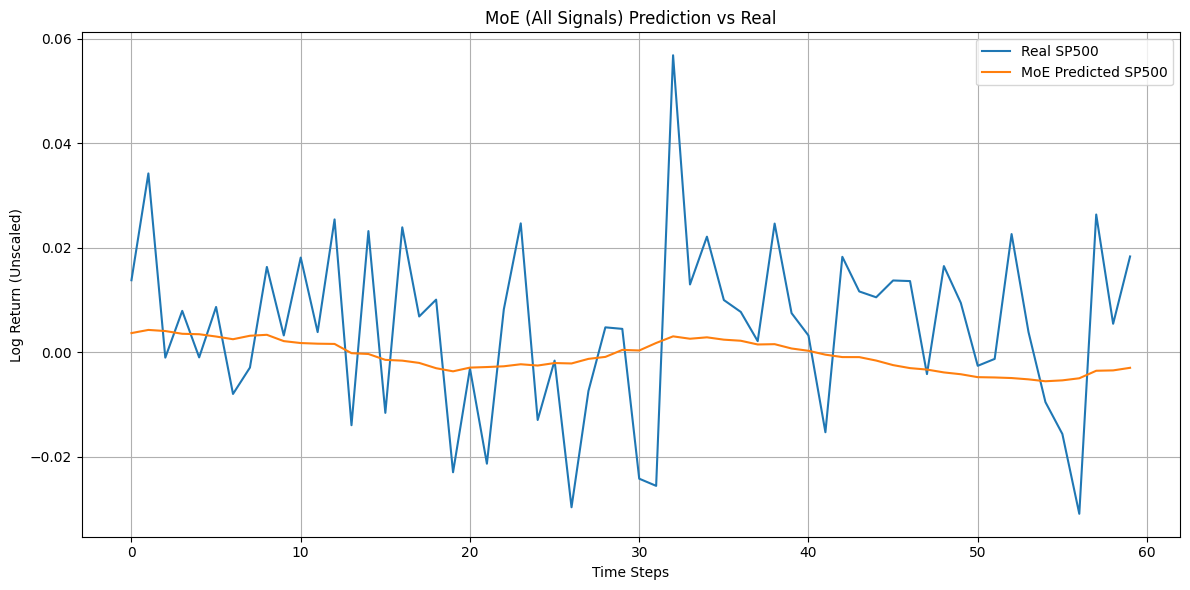

Directional Accuracy: 69.49%
Mean Squared Error: 0.000284
Average Gating Weights over Test Set:
  LSTM        : 0.5107
  Transformer : 0.4882
  Kalman/FXNet: 0.0011


In [8]:
features = macro_features + technical_features
X_all = df[features].values
scaler_all = MinMaxScaler()
X_all_scaled = scaler_all.fit_transform(X_all)
X_all_seq, y_all_seq = create_sequences(X_all_scaled, y_scaled, seq_length)
X_train_all, y_train_all, X_val_all, y_val_all, X_test_all, y_test_all = train_val_test_split(X_all_seq, y_all_seq)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load("lstm_model_all_signals.pth", map_location=device)
transformer_model = torch.load("sp500_transformer_full.pth", map_location=device)
fx_net = torch.load("fxnet_full.pth", map_location=device)
lstm_model.eval()
transformer_model.eval()
fx_net.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model in [lstm_model, transformer_model, fx_net]:
    model.eval()
    for param in model.parameters():
        param.requires_grad = False


class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_experts=3):
        super(GatingNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


class MoEModel(nn.Module):
    def __init__(self, lstm, transformer, fx_net, input_dim):
        super(MoEModel, self).__init__()
        self.lstm = lstm
        self.transformer = transformer
        self.fx_net = fx_net
        self.gating = GatingNetwork(input_dim=input_dim, num_experts=3)

    def forward(self, x_macro):
        last_step = x_macro[:, -1, :] 

        lstm_out = self.lstm(x_macro)
        transformer_out = self.transformer(x_macro)

        kalman_preds = []
        for i in range(last_step.size(0)):
            with torch.no_grad():
                pred = self.fx_net(last_step[i].unsqueeze(0).to(device))
            kalman_preds.append(pred[0, 0].item())
        kalman_out = torch.tensor(kalman_preds, dtype=torch.float32, device=x_macro.device).unsqueeze(1)

        weights = self.gating(last_step)  

        out = (
            weights[:, 0:1] * lstm_out +
            weights[:, 1:2] * transformer_out +
            weights[:, 2:3] * kalman_out
        )
        return out, weights


moe = MoEModel(
    lstm=lstm_model,
    transformer=transformer_model,
    fx_net=fx_net,
    input_dim= X_all_seq.shape[2]
).to(device)

optimizer = optim.Adam(moe.gating.parameters(), lr=1e-3)
criterion = nn.MSELoss()
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_all, y_train_all), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_all, y_val_all), batch_size=batch_size)
epochs = 200
for epoch in range(epochs):
    moe.train()
    total_train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred, _ = moe(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    moe.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = moe(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(val_loader):.4f}")



test_loader = DataLoader(TensorDataset(X_test_all, y_test_all), batch_size=32, shuffle=False)
moe.eval()
preds = []
weights_all = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out, weights = moe(xb)
        preds.append(out.cpu().numpy())
        weights_all.append(weights.cpu().numpy())

preds = np.vstack(preds)
weights_all = np.vstack(weights_all)



sp500_pred = y_scaler.inverse_transform(preds)
sp500_real = y_scaler.inverse_transform(y_test_all.cpu().numpy())
real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(real, pred)

plt.figure(figsize=(12, 6))
plt.plot(real, label="Real SP500")
plt.plot(pred, label="MoE Predicted SP500")
plt.title("MoE (All Signals) Prediction vs Real")
plt.xlabel("Time Steps")
plt.ylabel("Log Return (Unscaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f"Mean Squared Error: {mse:.6f}")
avg_weights = np.mean(weights_all, axis=0)
print("Average Gating Weights over Test Set:")
print(f"  LSTM        : {avg_weights[0]:.4f}")
print(f"  Transformer : {avg_weights[1]:.4f}")
print(f"  Kalman/FXNet: {avg_weights[2]:.4f}")